In [133]:
import sys
sys.path += ['../src/']
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
import numpy as np
import torch
import torch.optim as optim
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy.special import logit, expit
import torch.nn as nn

### Why do we have  a discontinuity in the loss function at the varying of $\epsilon$?

In [135]:
N, T, edge_per_t = 100, 200, 10
epsilon, mu = 0.2, 0.6
seed = 9

rho = 100

X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)

100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


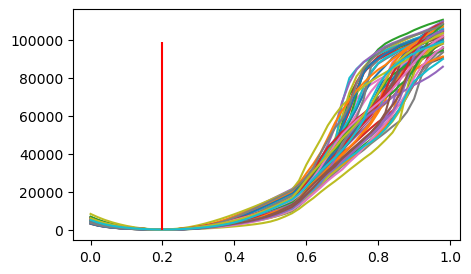

In [136]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3))

for seed in tqdm(range(50)):
    X_, edges_ = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)
    
    losses = est_bc.losses_closure(edges_, X_, rho, epsilon_values = np.arange(0,1,0.02), loss = nn.BCELoss(reduction="sum"))
    ax.plot(losses[0], losses[1])
    
ax.vlines(epsilon, ymin = -100, ymax = np.max(losses), color = "red")

Let us check when the 2nd derivative is exploding

In [139]:
losses[0][1:-1][list(np.abs(np.diff(losses[1], 2)) > 500)]

array([0.56, 0.58, 0.64, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82,
       0.84])

In [140]:
def show_discontinuity_losses(epsilon, mu, N = 200, T = 50, edge_per_t = 10, rho = 100, epsilon_values = np.arange(0,1,0.01), second_diff_threshold = 10):
    X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu)
    
    
    losses = est_bc.losses_closure(edges, X, rho, epsilon_values = epsilon_values)[1]
    which_epsilon = np.argmin(np.abs(epsilon_values - epsilon))
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3))
    
    first_differences = np.diff(losses, n = 1)
    second_differences = np.diff(losses, n = 2)
    for k in np.arange(which_epsilon, len(np.diff(losses, n = 2))):
        if np.abs(second_differences[k]) > second_diff_threshold:
            break
    
    line_limits_loss = np.max(losses), np.min(losses) 
    line_limits_diff1 = np.max(first_differences), np.min(first_differences) 
    line_limits_diff2 = np.max(second_differences), np.min(second_differences) 

    ax0.plot(epsilon_values, losses)
    ax0.vlines(epsilon, ymin = line_limits_loss[1], ymax = line_limits_loss[0], color = "red")
    ax0.vlines(epsilon_values[k], ymin = line_limits_loss[1], ymax = line_limits_loss[0], color = "red", linestyles = "dashed")
    
    ax1.plot(epsilon_values[1:], first_differences)
    ax1.vlines(epsilon_values[k], ymin = line_limits_diff1[1], ymax = line_limits_diff1[0], color = "red", linestyles = "dashed")
    
    ax2.plot(epsilon_values[1:-1], second_differences)
    ax2.vlines(epsilon_values[k], ymin = line_limits_diff2[1], ymax = line_limits_diff2[0], color = "red", linestyles = "dashed")
    
    fig.show()
    return (epsilon, mu, epsilon_values[k])

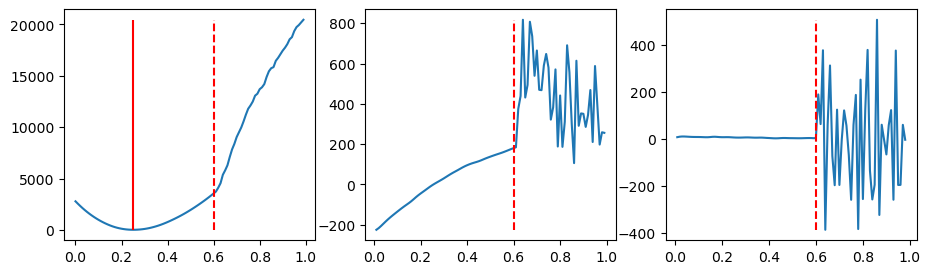

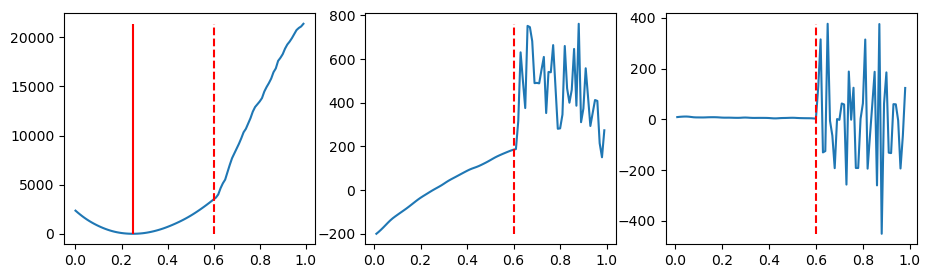

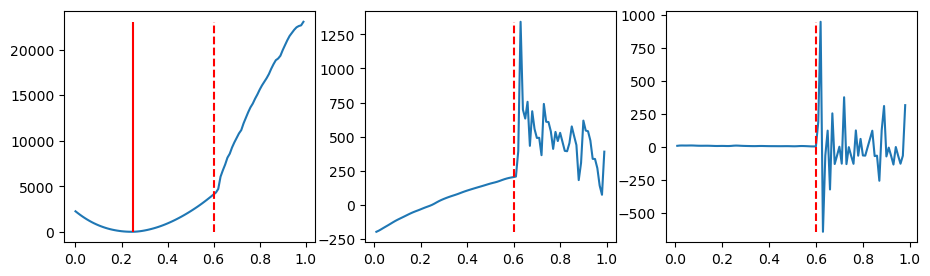

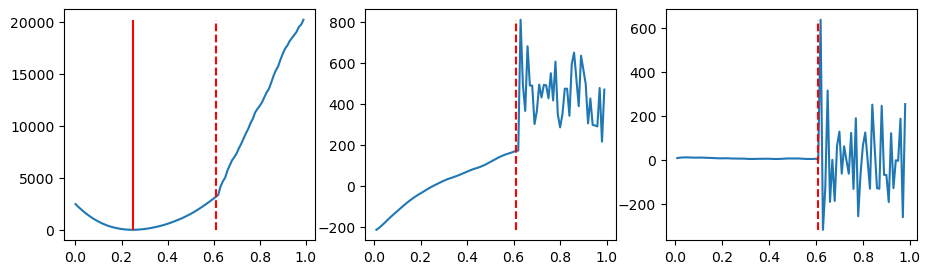

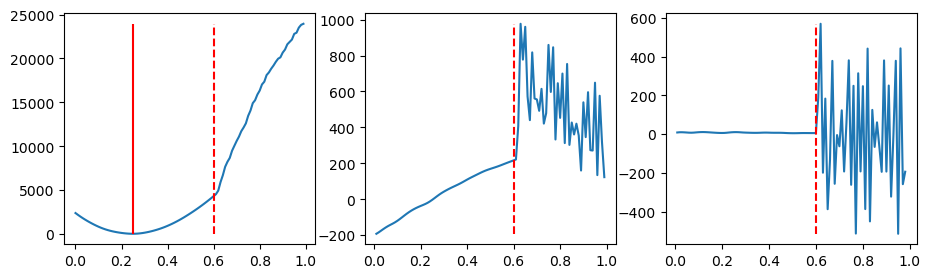

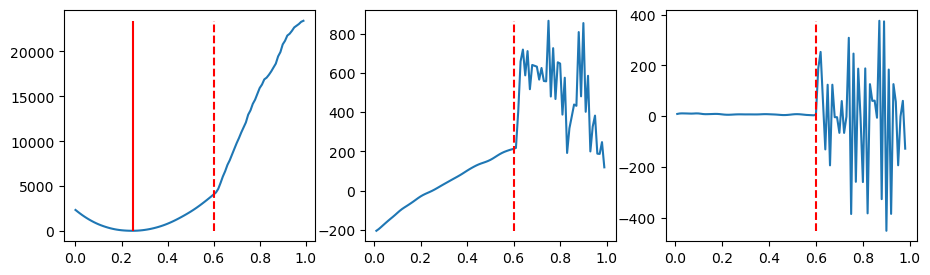

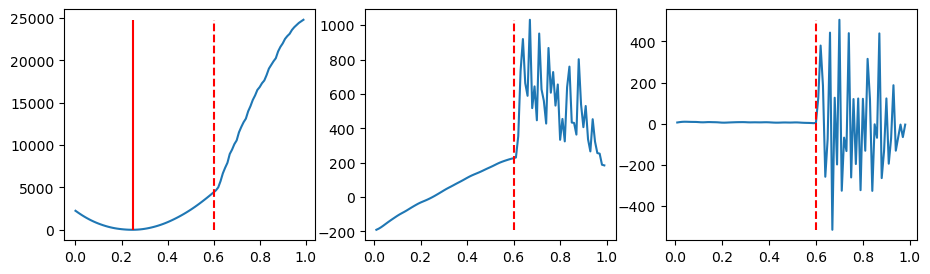

In [141]:
simulations_discontinuities = []

epsilon = 0.25

for mu in np.arange(0.1, 0.8, 0.1):
    simulations_discontinuities.append(show_discontinuity_losses(epsilon, mu, rho = 100, second_diff_threshold = 10))

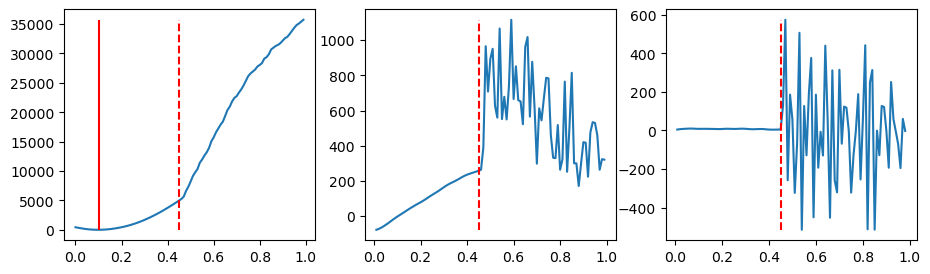

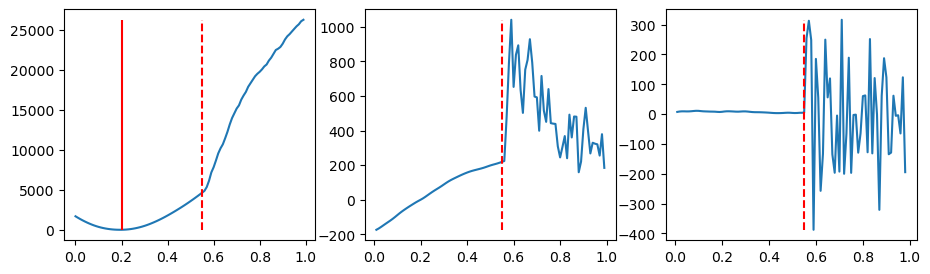

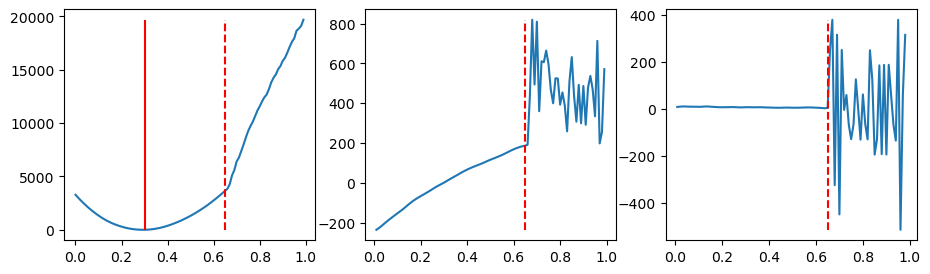

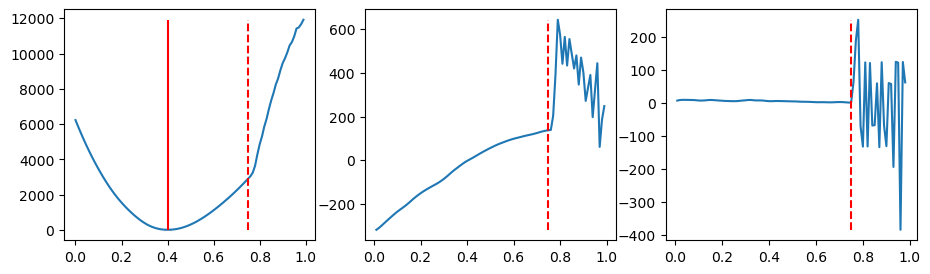

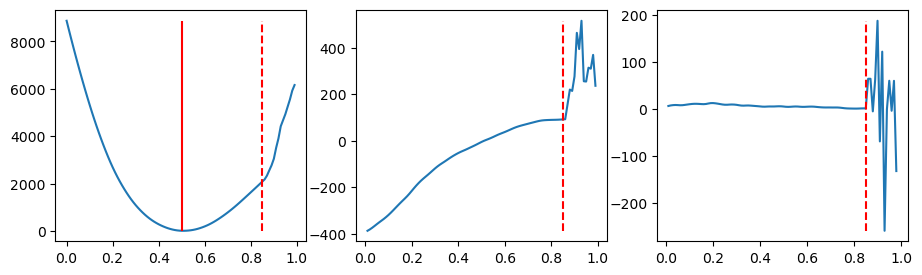

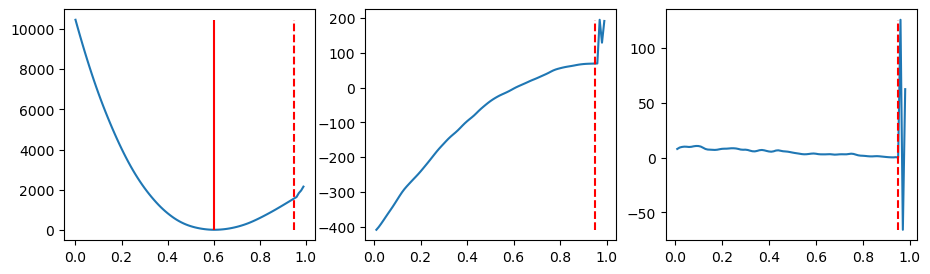

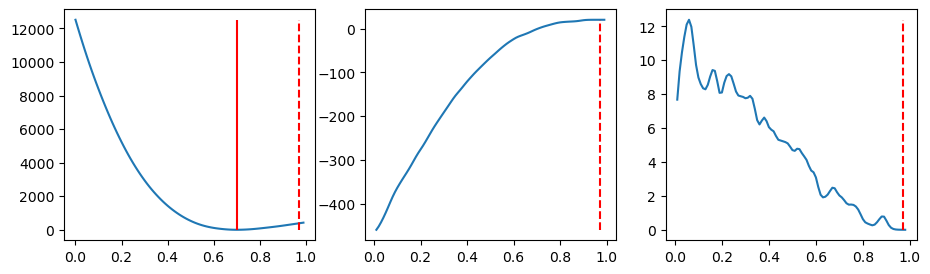

In [142]:
simulations_discontinuities = []

mu = 0.1

for epsilon in np.arange(0.1, 0.8, 0.1):
    simulations_discontinuities.append(show_discontinuity_losses(epsilon, mu, rho = 100, second_diff_threshold = 10))

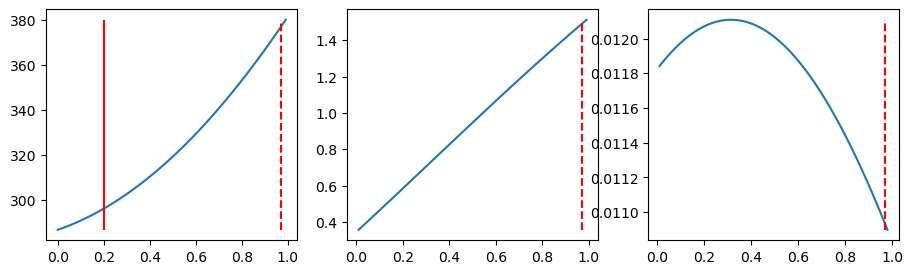

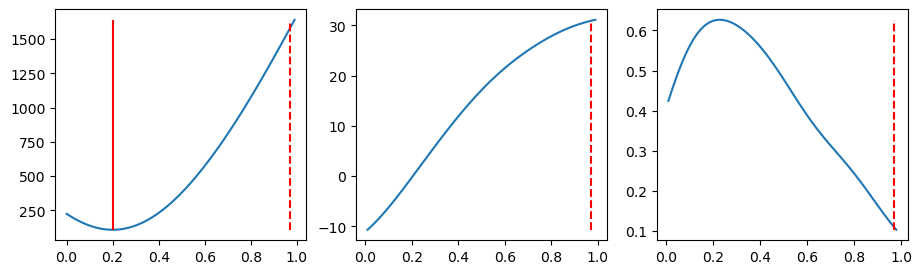

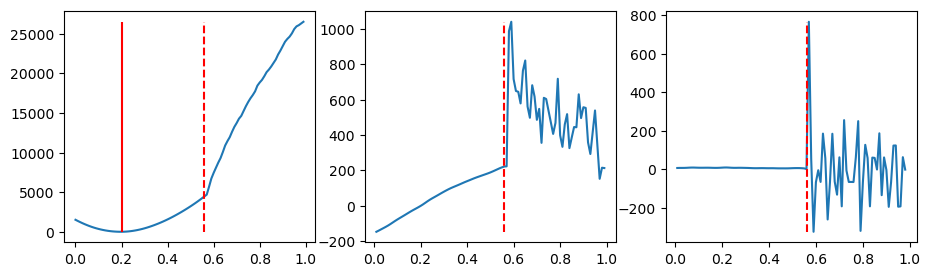

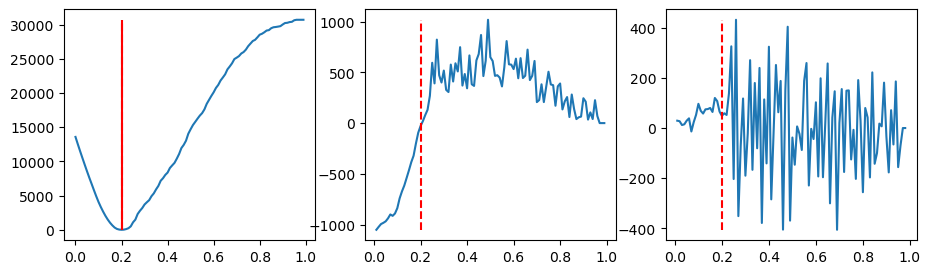

In [143]:
simulations_discontinuities = []

mu = 0.1
epsilon = 0.2
for rho in [1, 10, 100, 1000]:
    simulations_discontinuities.append(show_discontinuity_losses(epsilon, mu, rho = rho, second_diff_threshold = 10))

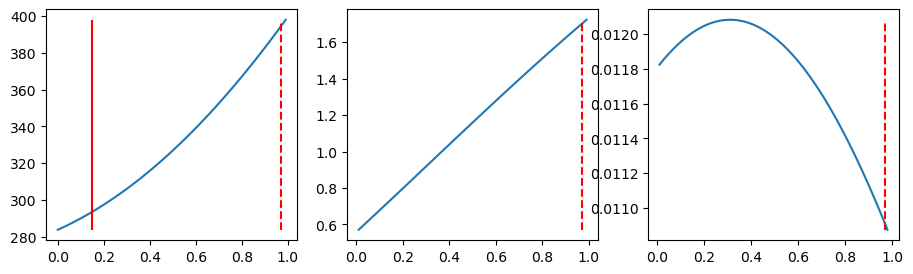

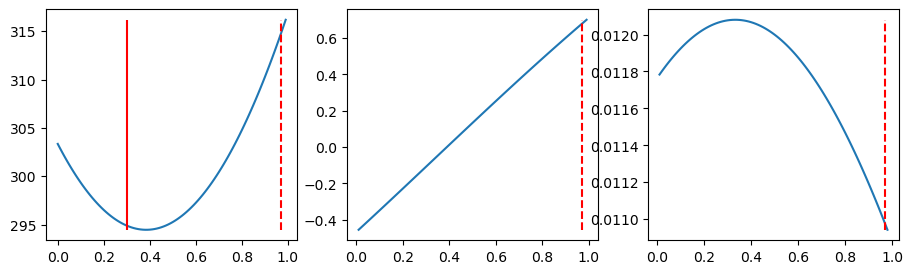

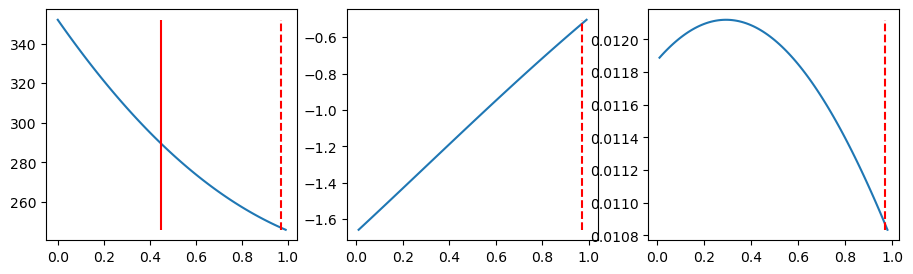

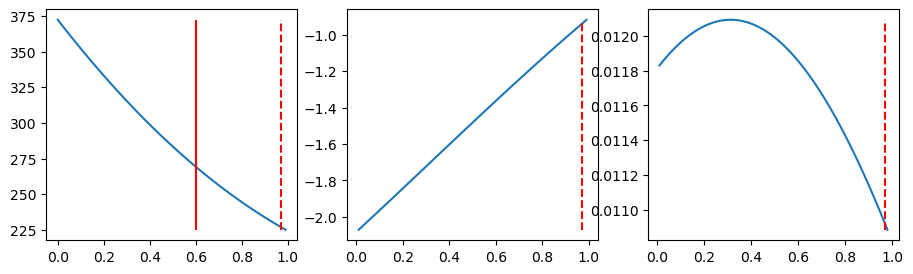

In [144]:
simulations_discontinuities = []

mu = 0.1
rho = 1
for epsilon in [0.15, 0.3, 0.45, 0.6]:
    simulations_discontinuities.append(show_discontinuity_losses(epsilon, mu, rho = rho, second_diff_threshold = 10))

The discontinuity:
- does not depend on $\mu$
- depends linearly on $\epsilon$
- get farther at the decrease of $\rho$

Moreover:
- with $\rho$ = 1 the estimation fails

### What happens?
What does it mean to vary our estimation of $\epsilon$?

For each interacting nodes, u v, plot $\kappa = \sigma(\rho * (\epsilon - \Delta x))$, and color them on the basis of whether the interaction occurred or not.

The interaction will be predicted positive with probability $\kappa$.

In [145]:
def print_kappa_s(epsilon, X, edges, logit = True, rho = 100):
    _, edge_per_t, _ = edges.size()
    T, N = X.size()
    diff_X = sim_bc.differences_tensor(X, N, T)
    uvst = sim_bc.convert_edges_uvst(edges)
    u,v,s,t = uvst
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7,3))
    
    if logit:
        kappa = rho * (epsilon - torch.abs(diff_X))
        ax.hlines(0, xmin = 0, xmax = (T-1) * edge_per_t, colors = "red")
    else:
        kappa = torch.sigmoid(rho * (epsilon - torch.abs(diff_X)))
        ax.hlines(0.5, xmin = 0, xmax = (T-1) * edge_per_t,  colors = "red")
    
    
    ax.scatter(np.arange((T - 1) * edge_per_t), kappa[t,u,v], c = s, s = 10)
    return kappa[t,u,v], s.double()


In [146]:
N, T, edge_per_t = 100, 200, 10
epsilon, mu = 0.1, 0.6
seed = 999

rho = 100

X, edges = est_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)

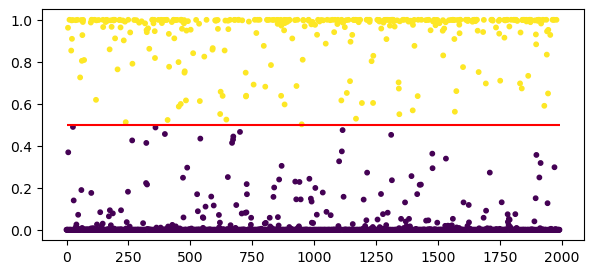

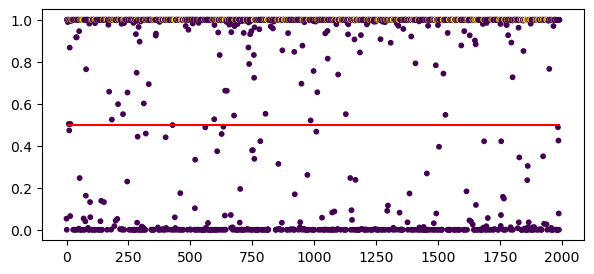

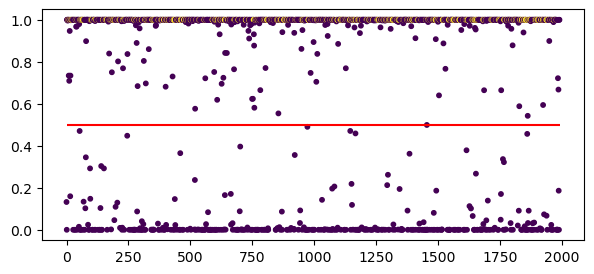

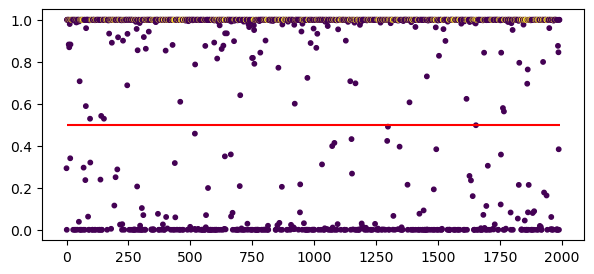

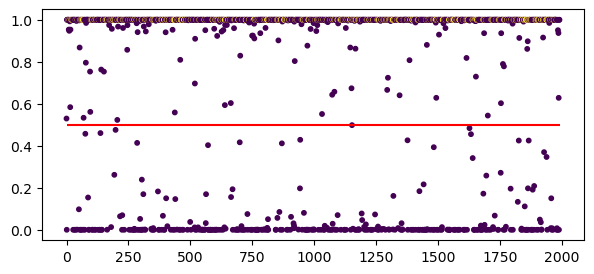

In [147]:
kappa_list = []

for eps in [epsilon, 0.54, 0.55, 0.56, 0.57]:
    kappa_list.append(print_kappa_s(eps, X, edges, logit = False, rho = 100))


### Represent the sigmoid

In [148]:
def plot_sigmoid_and_diffx(edges, X, parameter_list, with_logit = False):
    _, edge_per_t, _ = edges.size()
    T, N = X.size()
    diff_X = sim_bc.differences_tensor(X, N, T)
    uvst = sim_bc.convert_edges_uvst(edges)
    u,v,s,t = uvst

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9,3))
    for epsilon, rho in parameter_list:
        x = np.arange(-1, 1, 0.01)
        kappa_diffx = lambda x: expit(rho * (epsilon - np.abs(x)))
        if with_logit:
            y = expit(kappa_diffx(x))
        else:
            y = kappa_diffx(x)
        
        ax.plot(x, y)

    ax.scatter(diff_X[t,u,v], s, c = s, s = 10)



In [149]:
N, T, edge_per_t = 100, 200, 10
epsilon, mu = 0.2, 0.6
seed = 9

rho = 100

X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)

The loss function is given by the sum of the distances from points to the sigmoid function ($\kappa = \sigma(\rho * (\epsilon - \Delta x$) ) .

**Vary $\epsilon$**

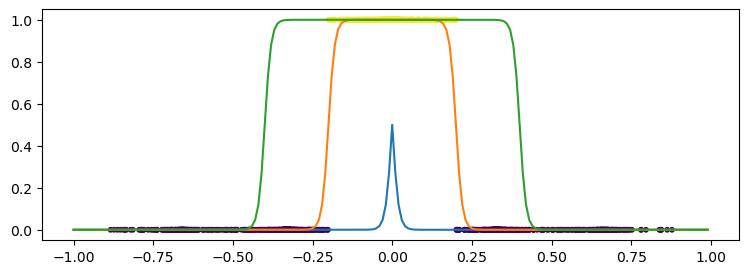

In [150]:
plot_sigmoid_and_diffx(edges, X, [(0., 100), (0.2, 100), (0.4, 100)])

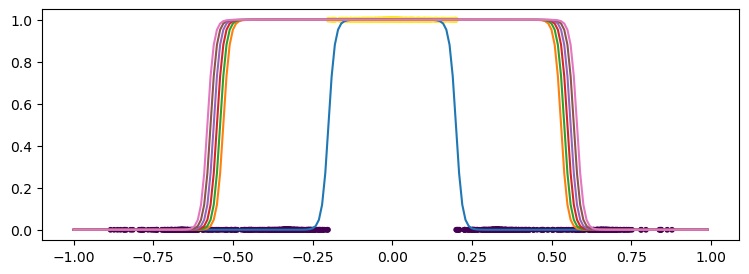

In [151]:
plot_sigmoid_and_diffx(edges, X, [(0.2, 100),(0.53, 100),(0.54, 100), (0.55, 100), (0.56, 100), (0.57, 100), (0.58, 100)])

**Vary $\rho$**

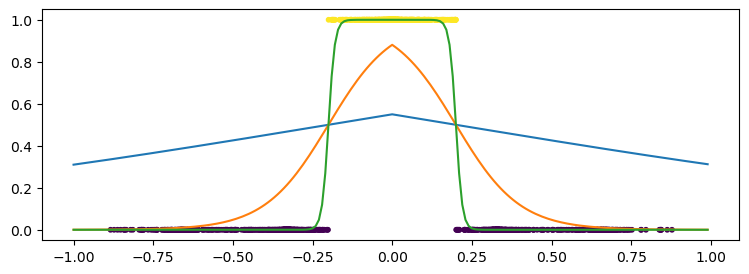

In [152]:
plot_sigmoid_and_diffx(edges, X, [(0.2, 1), (0.2, 10), (0.2, 100)])

**What happens with $\rho$ = 0?**

It estimates $\epsilon$ = 0 

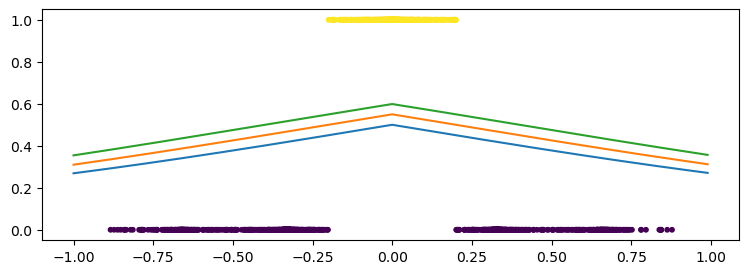

In [153]:
plot_sigmoid_and_diffx(edges, X, [(0., 1), (0.2, 1), (0.4, 1)])

## Try different loss function

### Stabilization
We can stabilize the BCE by applying the sigmoid to inputs data.

In [154]:
x = torch.rand([10]) 
y = torch.from_numpy(np.repeat([0.,1.], 5)).float()

In [155]:
def manual_bce(x,y):
    loss = -torch.sum(y * torch.log(x) + (1-y) * torch.log(1-x)) / x.size()[0]
    return loss

def manual_bce_w(x,y):
    xs = torch.sigmoid(x)
    loss = -torch.sum(y * torch.log(xs) + (1-y) * torch.log(1 - xs)) / x.size()[0]
    return loss


In [156]:
manual_bce(x,y), manual_bce_w(x,y) , manual_bce(torch.sigmoid(x),y)

(tensor(0.8242), tensor(0.7147), tensor(0.7147))

In [157]:
bce_loss = nn.BCELoss()
bce_loss_w = nn.BCEWithLogitsLoss()

bce_loss(x,y), bce_loss(torch.sigmoid(x), y), bce_loss_w(x, y)

(tensor(0.8242), tensor(0.7147), tensor(0.7147))

In [158]:
class StableBCELoss(nn.modules.Module):
    
    def __init__(self):
        super(StableBCELoss, self).__init__()
    
    def forward(self, input, target):
        neg_abs = - input.abs()
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.sum()



100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.94it/s]


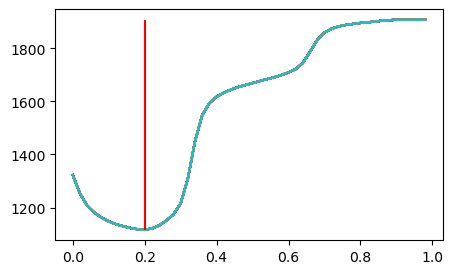

In [160]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3))

for seed in tqdm(range(50)):
    X_, edges_ = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)
    
    losses = est_bc.losses_closure(edges, X, rho, loss = StableBCELoss(), epsilon_values = np.arange(0,1,0.02)) 
    ax.plot(losses[0], losses[1])

ax.vlines(epsilon, ymin = min(losses[1]), ymax = max(losses[1]), color = "red")


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.08it/s]


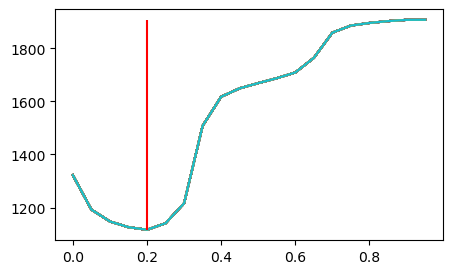

In [161]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3))

for seed in tqdm(range(50)):
    X_, edges_ = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)
    losses = est_bc.losses_closure(edges, X, rho, loss = nn.BCEWithLogitsLoss(reduction="sum")) 
    ax.plot(losses[0], losses[1])

ax.vlines(epsilon, ymin = min(losses[1]), ymax = max(losses[1]), color = "red")


In [163]:
N, T, edge_per_t = 100, 200, 10
epsilon, mu = 0.2, 0.6
seed = 9

rho = 10

X, edges = sim_bc.simulator(N, T, edge_per_t, epsilon, mu, seed)

diff_X = sim_bc.differences_tensor(X, N, T)
uvst = sim_bc.convert_edges_uvst(edges)
u,v,s,t = uvst

print("BCELoss")
for k in np.arange(7):
    rho = 10 ** k
    print("rho 10^", k, "loss", round(est_bc.tot_neg_log_likelihood(uvst, rho, epsilon, T, diff_X[t,u,v], loss = nn.BCELoss(reduction = "sum")).item(), 3))
    
print("BCEWithLogitsLoss")
for k in np.arange(7):
    rho = 10 ** k
    print("rho 10^", k, "loss", round(est_bc.tot_neg_log_likelihood(uvst, rho, epsilon, T, diff_X[t,u,v], loss = nn.BCEWithLogitsLoss(reduction = "sum")).item(), 3))
    

BCELoss
rho 10^ 0 loss 1190.845
rho 10^ 1 loss 380.23
rho 10^ 2 loss 15.512
rho 10^ 3 loss 2.558
rho 10^ 4 loss 0.057
rho 10^ 5 loss 0.0
rho 10^ 6 loss 0.0
BCEWithLogitsLoss
rho 10^ 0 loss 1530.369
rho 10^ 1 loss 1256.415
rho 10^ 2 loss 1116.323
rho 10^ 3 loss 1111.941
rho 10^ 4 loss 1111.179
rho 10^ 5 loss 1111.164
rho 10^ 6 loss 1111.164


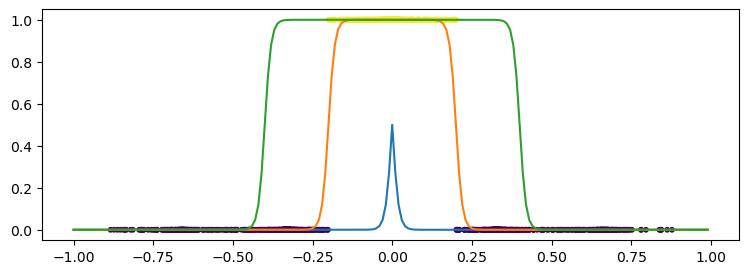

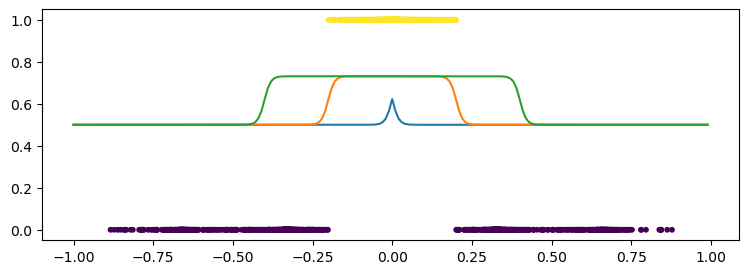

In [164]:
for u in [False, True]:
    plot_sigmoid_and_diffx(edges, X, [(0., 100), (0.2, 100), (0.4, 100)], with_logit = u)